<img align="center" src="http://sydney.edu.au/images/content/about/logo-mono.jpg">
<h1 align="center" style="margin-top:10px">Statistical Learning with Python</h1>
<h2 align="center" style="margin-top:20px">Lecture 4: Variable Selection and Regularisation</h2>
<br>

This lesson introduces regularisation, one of the most important ideas in machine learning. 

<a href="#1.House-Pricing Data">House Pricing Data</a> <br>
<a href="#2.Exploratory-Data-Analysis">Exploratory Data Analysis</a> <br>
<a href="#3.Feature-Engineering">Feature Engineering</a> <br>
<a href="#4.Ridge-Regression">Subset Selection</a> <br>
<a href="#5.Ridge-Regression">Ridge Regression</a> <br>
<a href="#6.Lasso">Lasso</a> <br>
<a href="#7.Elastic-Net">Extensions</a> <br>
<a href="#8.Model-Evaluation">Model Evaluation</a> <br> 

In [1]:
# Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore') 

In [2]:
# Plot settings
sns.set_context('notebook') # optimises figures for notebook display
sns.set_style('ticks') # set default plot style
crayon = ['#4E79A7','#F28E2C','#E15759','#76B7B2','#59A14F', 
          '#EDC949','#AF7AA1','#FF9DA7','#9C755F','#BAB0AB']
sns.set_palette(crayon) # set custom color scheme
%matplotlib inline
plt.rcParams['figure.figsize'] = (9, 6)

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score,  mean_absolute_error

### 1. House Pricing Data 

We use data from [De Cock (2011)](http://www.tandfonline.com/doi/abs/10.1080/10691898.2011.11889627), who compiled a detailed dataset of residential property sales in a North American city. It is used in one of the most popular [Kaggle competitions](https://www.kaggle.com/c/house-prices-advanced-regression-techniques) for practice. This dataset is characterised by a moderately large number of predictor variables (81, including categorical, ordinal, discrete, and continuous variables). See the [documentation](https://ww2.amstat.org/publications/jse/v19n3/Decock/DataDocumentation.txt) for a description of the original variables. 

I cleaned and processed the original dataset into a version that is ready analysis. The dataset has 196 variables after coding the categorical predictors using dummy variables and the creation of other relevant variables. 

In [4]:
data=pd.read_csv('Data/ames-processed-regression.csv')
data.head()

,LotFrontage,LotArea,MasVnrArea,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,2ndFlrSF,LowQualFinSF,GrLivArea,GarageArea,...,3SsnPorchZero,ScreenPorchZero,PoolAreaZero,MiscValZero,FireplaceQuNA,Condition_Artery,Condition_Railroad,Condition_Feedr,Condition_PosN,SalePrice
0,141.0,10.366278,112.0,0.0,441.0,1080.0,0,0,7.412160,6.270988,...,1,1,1,1,0,0,0,0,0,215000
1,80.0,9.360655,0.0,144.0,270.0,882.0,0,0,6.797940,6.594413,...,1,0,1,1,1,0,0,1,0,105000
2,81.0,9.565704,108.0,0.0,406.0,1329.0,0,0,7.192182,5.746203,...,1,1,1,0,1,0,0,0,0,172000
3,93.0,9.320091,0.0,0.0,1045.0,2110.0,0,0,7.654443,6.259581,...,1,1,1,1,0,0,0,0,0,244000
4,74.0,9.534595,0.0,0.0,137.0,928.0,701,0,7.395722,6.180017,...,1,1,1,1,0,0,0,0,0,189900


In [5]:
variables=pd.read_csv('Data/ames-processed-regression-variables.csv')
variables.head()

,variable,type
0,2ndFlrSF,continuous
1,Age,continuous
2,BsmtFinSF2,continuous
3,BsmtUnfSF,continuous
4,EnclosedPorch,continuous


We the split the data into training and test sets. We use a small training dataset to better illustrate the advantages of regularisation. 

In [6]:
response='SalePrice'
predictors=list(data.columns.values[:-1])

# Randomly split indexes
index_train, index_test  = train_test_split(np.array(data.index), train_size=0.3, random_state=10)

# Write training and test sets
train = data.loc[index_train,:].copy()
test =  data.loc[index_test,:].copy()

y_train = train[response].to_numpy() 
y_test = test[response].to_numpy() 

X_train = train[predictors].to_numpy() 
X_test = test[predictors].to_numpy() 

### 2. Exploratory Data Analysis

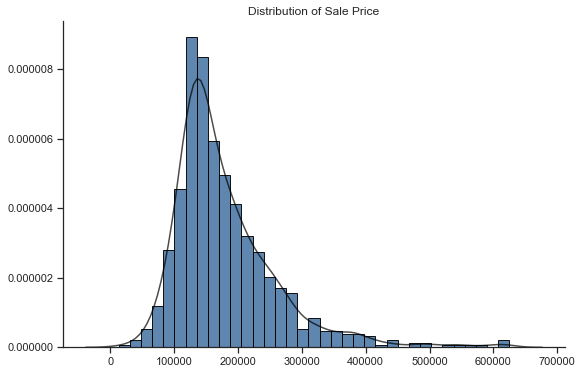

In [7]:
from statlearning import plot_dist
plot_dist(y_train)
plt.title('Distribution of Sale Price')
plt.show()

Many of the numerical variables have a substantial number of zeros, since they refer to variables that do not apply to all houses (such as the second floor area). The dataset includes additional constructed features to account for this feature of the data.

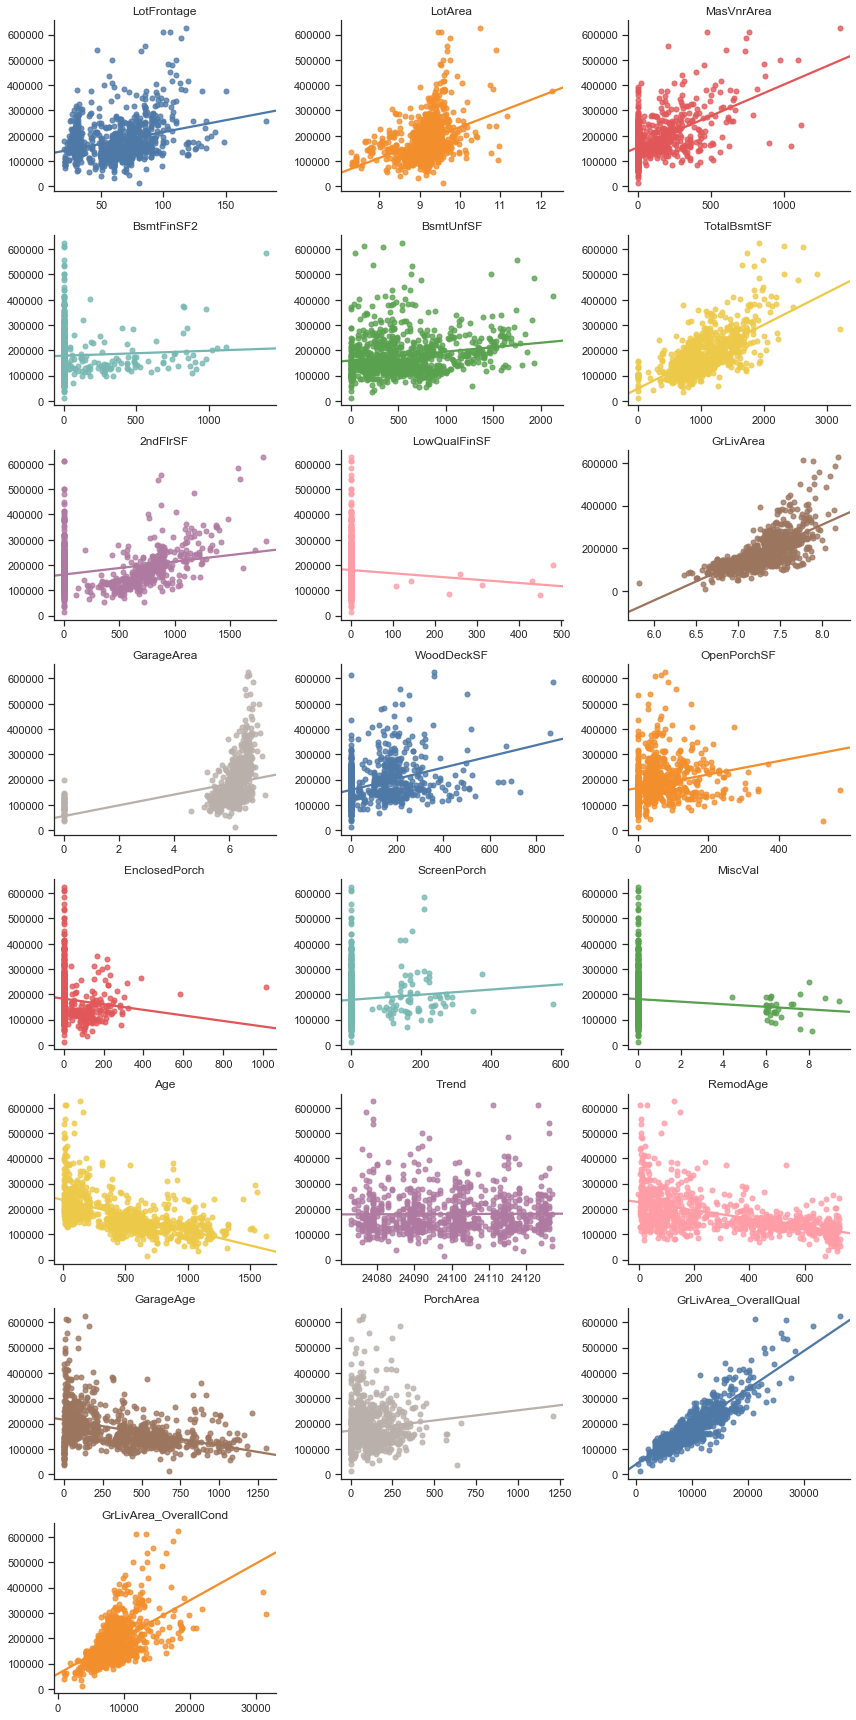

In [8]:
from statlearning import plot_regressions
continuous = list(variables[variables['type']=='continuous'].index)
plot_regressions(train.iloc[:,continuous], y_train)
plt.show()

### 3. Feature Engineering

**3.1 Response Transformation**

The above plots show that (i) the response variable is right skewed (ii) there are nonlinear relationships between the response and certain predictors (iii) the noise has non-constant variance (see for example the funnel shape in some of the plots). 

It is very common to observe these three patterns together in economic data, for reasons such as diminishing returns (additional space becomes less valuable if you have more space to begin with) and inflation (prices, salaries, etc, increase in percentage terms, not in a linear fashion).

In this situation, transforming the response will typically improve performance, as it is a parsimonious way to account for nonlinearities, reduce skewness, and reduce heteroscedasticity. The log transformation is the most common transformation of this type. 

In [9]:
y_train = np.log(train[response])
y_test = np.log(test[response])

Compare the univariate plots below with the original. 

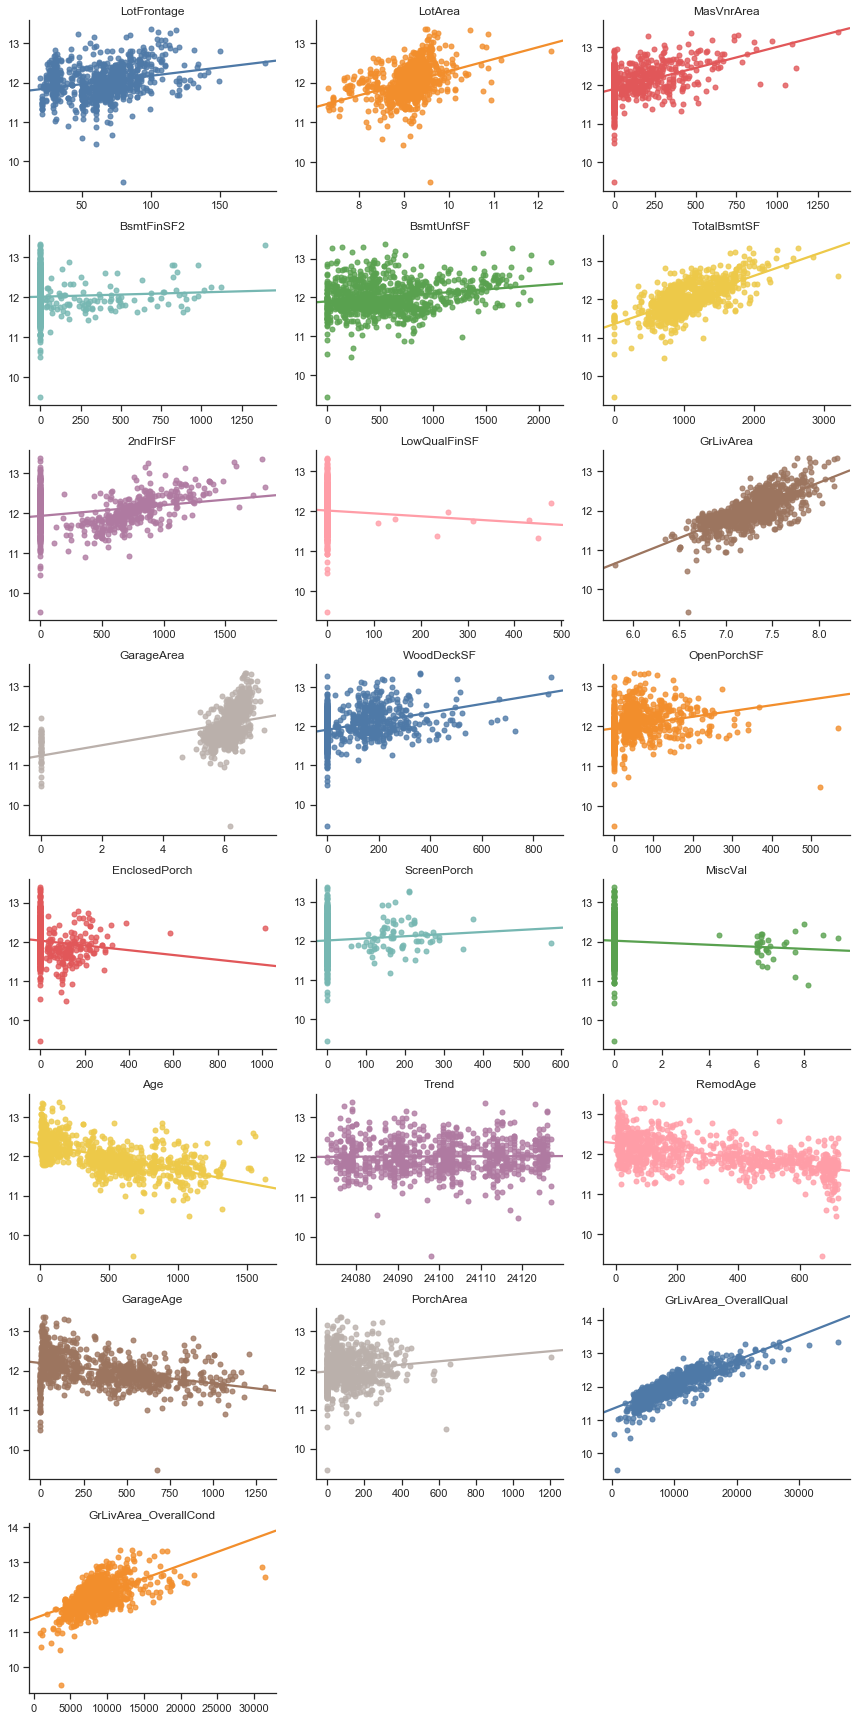

In [10]:
from statlearning import plot_regressions

plot_regressions(train.iloc[:,continuous], y_train)
plt.show()

**3.2 Scaling the Predictors**

It is essential to scale the predictors before fitting regularised linear methods. Like several other machine learning algorithms, regularised linear methods do not perform well when predictors have very different scales (because the penalty term in the objective function for training treats all coefficients as comparable).  

The most common type of scaling is standardisation, where we transform each predictor by subtracting its sample average and diving the result by its standard deviation. The Scikit-Learn [<TT>StandardScaler</TT>](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) method makes it easy to process the data in this way.

We have two ways of implementing a workflow that includes scaling. The first is to use the standard scaler to preprocess the design matrix, and then work with the transformed as usual. 

In [11]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

Another option is to use a Scikit-Learn [pipeline](http://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html#sklearn.pipeline.Pipeline), which allows the user to combine transformations with a final estimator. Here's an example. 

In [12]:
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline

ridge = Pipeline([
    ('scaler', StandardScaler()),
    ('estimator', Ridge()),
])

ridge.fit(X_train, y_train)
y_pred = ridge.predict(X_test)
print(y_pred[0]) 

12.089140717093516


### 4. Subset Selection

In [13]:
from statlearning import forward
fwd = forward()
fwd.fit(X_train_scaled, y_train)

In [25]:
len(fwd.subset)

48

### 5. Ridge Regression

In [14]:
from sklearn.linear_model import RidgeCV

alphas = list(np.logspace(-15, 15, 151, base=2))
ridge = RidgeCV(alphas=alphas, cv=5)
ridge.fit(X_train_scaled, y_train)

RidgeCV(alphas=array([3.05176e-05, 3.50555e-05, ..., 2.85262e+04, 3.27680e+04]),
    cv=5, fit_intercept=True, gcv_mode=None, normalize=False, scoring=None,
    store_cv_values=False)

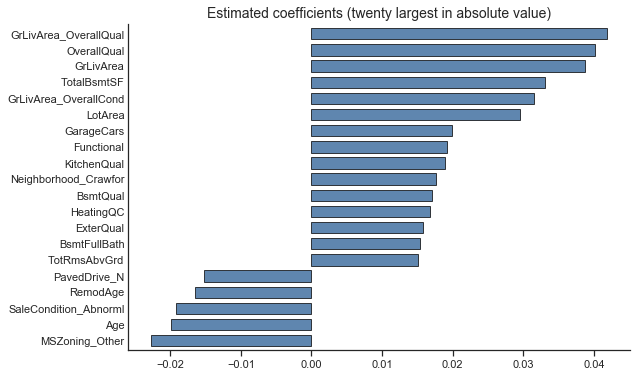

In [15]:
from statlearning import plot_coefficients
plot_coefficients(ridge, predictors)
plt.show()

### 5. Lasso

We use the [<TT>LassoCV</TT>](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html) class to fit and tune the lasso model. The reason for this class, as opposed to running a grid search on the [<TT>Lasso</TT>](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html) class, is that there is an efficient algorithm for computing the path of solutions as we vary the lasso penalty. The same is true of other models. 

Below, we present code according to the two ways of handling predictor scaling. 

In [16]:
from sklearn.linear_model import LassoCV

lasso = LassoCV(cv=5)
lasso.fit(X_train_scaled, y_train)

LassoCV(alphas=None, copy_X=True, cv=5, eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=100, n_jobs=None, normalize=False,
    positive=False, precompute='auto', random_state=None,
    selection='cyclic', tol=0.0001, verbose=False)

The lasso shrinks 79 coefficients to zero. 

In [17]:
np.sum(lasso.coef_==0.0)

79

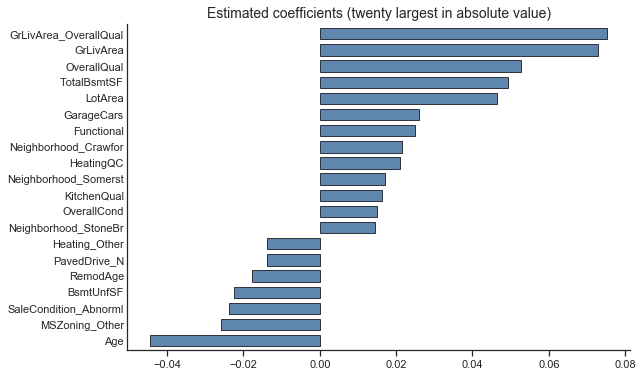

In [18]:
plot_coefficients(lasso, predictors)
plt.show()

### 6. Extensions

In [19]:
from sklearn.linear_model import ElasticNetCV

enet = ElasticNetCV(l1_ratio=[0.01,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9, 0.99], cv=5)
enet.fit(X_train_scaled, y_train)

ElasticNetCV(alphas=None, copy_X=True, cv=5, eps=0.001, fit_intercept=True,
       l1_ratio=[0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99],
       max_iter=1000, n_alphas=100, n_jobs=None, normalize=False,
       positive=False, precompute='auto', random_state=None,
       selection='cyclic', tol=0.0001, verbose=0)

In [20]:
enet.l1_ratio_

0.01

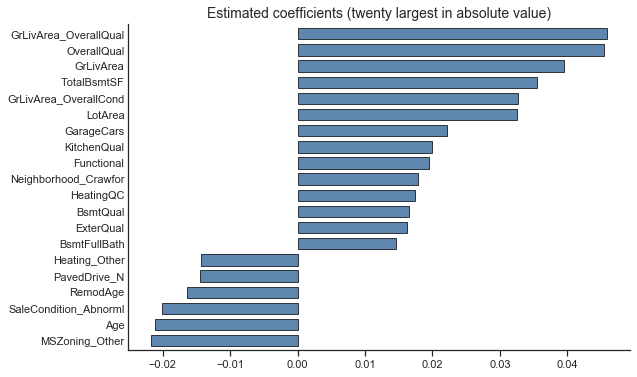

In [21]:
plot_coefficients(enet, predictors)
plt.show()

In [22]:
from statlearning import AdaLassoCV
adalasso = AdaLassoCV(gamma=1)
adalasso.fit(X_train_scaled, y_train)

### 7. Model Evaluation

We compute the test results for the original price scale.

As a technical detail, we should make a bias correction when predicting the original response based on a model for a transformed response. However, the adjustment is very small for the current example (see below), so that we ignore it for simplicity. 

In [23]:
ols = LinearRegression()
ols.fit(X_train_scaled, y_train)

columns=['Test RMSE', 'Test R2', 'Test MAE']
rows=['OLS','Forward', 'Lasso', 'Ridge', 'Elastic Net', 'AdaLasso']
results=pd.DataFrame(0.0, columns=columns, index=rows) 

methods=[ols, fwd, lasso, ridge, enet, adalasso]

for i, method in enumerate(methods):
    
    y_pred=method.predict(X_test_scaled)   
    results.iloc[i,0] = np.sqrt(mean_squared_error(y_test, y_pred))
    results.iloc[i,1] = r2_score(y_test, y_pred)
    results.iloc[i,2] = mean_absolute_error(y_test, y_pred)

results.round(3)

,Test RMSE,Test R2,Test MAE
OLS,0.125,0.904,0.084
Forward,0.121,0.911,0.081
Lasso,0.119,0.913,0.079
Ridge,0.123,0.907,0.082
Elastic Net,0.122,0.909,0.081
AdaLasso,0.119,0.913,0.080


In [24]:
# This cells formats the notebook for display online.  Please omit it from your work.  
from IPython.core.display import HTML
style = open('jstyle.css', "r").read()
HTML('<style>'+ style +'</style>')